<h1><center> Building Recommender Systems: Latest MovieLens Dataset (small 100k) </center></h1>
<h2><center> Southern Methodist University: Masters of Data Science </center></h2>
<h3><center> MSDS 7331: Data Mining - Lab 3 </center></h3>
<h4><center> Jethin Abraham, Laurie Harris, Daniel Higdon, Jack Nelson </center></h4>

In [1]:
import zipfile
import os
from urllib import urlretrieve
import graphlab as gl
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

This non-commercial license of GraphLab Create for academic use is assigned to nelsonjohn@mail.smu.edu and will expire on December 02, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1512609152.log


<h2> Business Understanding 1 </h2>  
Describe the purpose of the data set you selected (i.e. why was this data collected in the first place?).  How will you measure the effectiveness of a good algorithm?  Why does your chosen validation method make sense for the specific dataset and the stakeholders needs?

<h3> Data Background and Purpose </h3>
The data set we are using to build a "recommender" system is made available by MovieLens<sup>[1]</sup>. MovieLens itself is a research site which is run by GroupLens. So, what, or who, is GroupLens? GroupLens is a research lab run by faculty from the University of Minnesota department of computer science and engineering. GroupLens' mission statement, found on their website (www.grouplens.org/about/what-is-grouplens/) is:

"We advance the theory and practice of social computing by building and understanding systems used by real people."

Students, faculty, and staff are involved in the running and research which is accomplished by GroupLens.

The MovieLens "product", which they created and maintain is a non-commercial research site which uses "collaborative filtering" to recommend movies to its users. By providing a recommendation service MovieLens can introduce users to movies they may not be familiar with, but may enjoy based on their past movie ratings. In return, the users are providing MovieLens with a richer data set on which to perform research and teach students.

<h3> Data Summary </h3>
While this is discussed in more detail in the "Data Understanding" section, a high-level understanding is important to understanding the business value of the data. The data is actually a collection of four data sets which can be joined together to identify users, the movies they've seen, how they rated them, and how they described the movies through the use of "tags" (typically short, free-form text descriptions). The ratings were collected between January 9, 1995 and October 16, 2016. It is important to note that MovieLens specifies that this is a "development" data set, which means that it may change over time. As such, it would not be appropriate for research results, as changes to underlying data will result in changes to the research outcomes<sup>[1]</sup>.

<h3> Model Measurement and Validation </h3>
We are going to explore both user based collaborative filtering (or user-item), as well as a item based method (item-item). We must take into account the quality of the results that we are able to achieve with both methods, but our preference would be to use the item-based method. User based methods does not scale as well, and ultimately we would like to scale our model for applications in even larger data sets. To measure the quality of our results we will rely on three metrics. 

<h4> Metric 1: RMSE </h4>
The first is root mean square error, or RMSE. This is simply the root mean square of the difference between the predicted rating and the actual rating (the error). We can calculate this on a per user basis and on a per item basis. Our business case is end-user focused, so we are more concerned with per user RMSE, as we want to best predicut how any given user would score a movie.

<h4> Metric 2: Per-User-Recall </h4>
The per-user-recall finds how many of the highly rated movies by any given user, did our model find? The formula, from Dr. Larson's notebook<sup>[4]</sup>, is below:

$$R(k)=\frac{|a \cap p_k|}{|a|} $$

<h4> Metric 3: Per-User-Precision </h4>
The per-user-precision is similar to per-user-recall, but approaches it from the opposite angle. Per-user-precision says of the items found by the model, how many were highly rated by the user? Again, the formula for per-user-precision, from Dr. Larson's notebook<sup>[4]</sup> is provided below:

$$P(k)=\frac{|a \cap p_k|}{k} $$

<h4> Stakeholder Needs </h4>
In summary, the dataset we have chosen was crafted specifically to serve the purpose we have chosen it for, which is to implement collaborative filtering to develop a recommender system. The target audience is end-users, or movie viewers would would like recommendations about what other movies they may enjoy. We will use their past ratings, as well as information about the types of movies they have seen and rated, to develop these predictions. Finally, we will use RMSE, per-user recall, and per-user-precision to measure the accuracy of our model.

<h2> Data Understanding 1 </h2>  
Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file.  Verify data quality: Are there missing values?  Duplicate data?  Outliers?  Are those mistakes?  How do you deal with these problems.

<h4> Reading in Files </h4>  
The MovieLens dataset is actually a collection of 4 comma separated values (csv) files that can you joined with certain ID fields.  This prevents unecessary duplicate data values for storage, similar to how relational databases are designed.  We begin by downloading the zip file from the url provided at https://grouplens.org/datasets/movielens/, opening the downloaded function, and extracting the contents.  A conditional was added for optimization if previously downloaded.  

In [2]:
#downloading MovieLens Latest Datasets-Small from https://grouplens.org/datasets/movielens/
if os.path.isdir('ml-latest-small/'):
    print 'MovieLens dataset already extracted and saved on local machine'
else:
    urlretrieve('http://files.grouplens.org/datasets/movielens/ml-latest-small.zip','ml-latest-small.zip')
    zfile = zipfile.ZipFile('ml-latest-small.zip')
    zfile.extractall()
    os.remove('ml-latest-small.zip')

MovieLens dataset already extracted and saved on local machine


<h4> Data Description and Meaning </h4>  
The contents of the zip file is a folder titled 'ml-latest-small' with four csv files inside: 'movies.csv', 'ratings.csv', 'tags.csv', and 'links.csv'.  The four files can be joined together using the following identification fields:
 - **userId**: <u>Type</u>: string, <u>Description</u>: unique MovieLens users that selected at random from the full set and anonymized.  The field can be used to link 'ratings.csv' and 'tags.csv'
 - **movieId**: <u>Type</u>: string, <u>Description</u>: unique movies with at least one rating in the dataset.  The field can be used to link 'ratings.csv', 'tags.csv', 'movies.csv', and 'links.csv'  
 
A description of each csv file and fields are as follows:  
  
<i><u>movies.csv</u></i>  
csv file of movies and their genres   
 - **movidId**: <u>Type</u>: string, <u>Description</u>: unique identifier for a movie  
 - **title**: <u>Type</u>: string, <u>Description</u>: textual title of of a movie  
 - **genres**: <u>Type</u>: list, <Description</u>: pipe-separated list for genre(s) describing a movie
     - 18 genres possible values to select from {Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western}
     - Not every movie lists a genre  
     
<i><u>ratings.csv</u></i>  
csv file of ratings for movies by MovieLens users   
 - **userId**: <u>Type</u>: string, <u>Description</u>: unique identifier for a MovieLens user  
 - **movieId**: <u>Type</u>: string, <u>Description</u>: unique identifier for a movie  
 - **rating**: <u>Type</u>: float, <u>Description</u>: rating given to a movie by MovieLens user on a 5-star scale with half-star increments  
 - **timestamp**: <u>Type</u>: int, <u>Description</u>: timestamp of rating represented as seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970  
  
<i><u>tags.csv</u></i>  
csv file of tags for movies chosen by MovieLens users  
 - **userId**: <u>Type</u>: string, <u>Description</u>: unique identifier for a MovieLens user  
 - **movieId**: <u>Type</u>: string, <u>Description</u>: unique identifier for a movie  
 - **tag**: <u>Type</u>: string, <u>Description</u>: a word or short phrase generated by a MovieLens user for a particular movie whose meaning user-specific  
  
<i><u>links.csv</u></i>  
csv file to link movie information from other movie databases  
 - **movieId**: <u>Type</u>: string, <u>Description</u>: unique identifier for a movie
 - **imdbId**: <u>Type</u>: string, <u>Description</u>: unique identifier for a movie used by http://www.imdb.com  
 - **tmdbId**: <u>Type</u>: string, <u>Description</u>: unique identifier for a movie used by http://www.themoviedb.org  

<h4> Verify Data Quality </h4>  

Now that we understand the dataset files as well as the type and meaning of each attribute.  Let's load each csv file into a GraphLab SFrame and view its output in the Canvas.  <u><i>Links.csv</i></u> will not be loaded since we are not using imdb or tmdb in this notebook.  
  
<h4><u><i>movies.csv</i></u></h4>  

In [3]:
movies_sf = gl.SFrame.read_csv('ml-latest-small/movies.csv', column_type_hints={'movieId':str})
movies_sf

Finished parsing file /Users/JackNelson/Documents/SMU/MSDS7331/Project3/Github/ml-latest-small/movies.csv

Parsing completed. Parsed 100 lines in 0.173235 secs.

Finished parsing file /Users/JackNelson/Documents/SMU/MSDS7331/Project3/Github/ml-latest-small/movies.csv

Parsing completed. Parsed 9125 lines in 0.022344 secs.

movieId,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy ...
2,Jumanji (1995),Adventure|Children|Fantasy ...
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride PartII (1995) ...,Comedy
6,Heat (1995),Action|Crime|Thriller
7,Sabrina (1995),Comedy|Romance
8,Tom and Huck (1995),Adventure|Children
9,Sudden Death (1995),Action
10,GoldenEye (1995),Action|Adventure|Thriller


In [4]:
movies_sf.show()

Canvas is accessible via web browser at the URL: http://localhost:55760/index.html
Opening Canvas in default web browser.


![title](screenshots/movies_sf.png)  
*Screenshot from GraphLab Canvas window*

Note that the pipe-separated list for the **genres** attribute did not read in as a list, but a string.  This is because the csv file is not in a format for GraphLab to recognize a list (current format: 'genre1|genre2|genre3', desired format: '[genre1, genre2, genre3]').  Since no clean way to make this conversion was identified in GraphLab, we will utilize pandas and the split function.  A new csv file, 'movies2.csv', is saved for GraphLab to read in.  The original pipe-separated list is kept in the new csv file as there may be benefit to recommending movies with the exact same set of genres.     

In [5]:
temp = pd.read_csv('ml-latest-small/movies.csv')

genre_list = [0]*len(temp['genres'])

for i in range(len(temp['genres'])):
    genre_list[i] = temp['genres'][i].split('|')
    
temp['genre_list'] = genre_list
temp.to_csv('ml-latest-small/movies2.csv')

The new csv file loaded over the existing GraphLab SFrame and viewed on the Canvas.

In [6]:
movies_sf = gl.SFrame.read_csv('ml-latest-small/movies2.csv', column_type_hints={'movieId':str}).remove_column('X1')
movies_sf

Finished parsing file /Users/JackNelson/Documents/SMU/MSDS7331/Project3/Github/ml-latest-small/movies2.csv

Parsing completed. Parsed 100 lines in 0.125716 secs.

These column type hints were not used: X1

Finished parsing file /Users/JackNelson/Documents/SMU/MSDS7331/Project3/Github/ml-latest-small/movies2.csv

Parsing completed. Parsed 9125 lines in 0.047279 secs.

movieId,title,genres,genre_list
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy ...,"[Adventure, Animation,Children, Comedy, ..."
2,Jumanji (1995),Adventure|Children|Fantasy ...,"[Adventure, Children,Fantasy] ..."
3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
5,Father of the Bride PartII (1995) ...,Comedy,[Comedy]
6,Heat (1995),Action|Crime|Thriller,"[Action, Crime, Thriller]"
7,Sabrina (1995),Comedy|Romance,"[Comedy, Romance]"
8,Tom and Huck (1995),Adventure|Children,"[Adventure, Children]"
9,Sudden Death (1995),Action,[Action]
10,GoldenEye (1995),Action|Adventure|Thriller,"[Action, Adventure,Thriller] ..."


In [7]:
movies_sf.show()

Canvas is updated and available in a tab in the default browser.


![title](screenshots/movies_sf_genrelist.png)  
*Screenshot from GraphLab Canvas window*

Now that the movie genres are properly classified as a list, we check to make sure there are no duplicates in the movieId field.  Each line should represent an independent movie to ensure no unecessary duplicates will be created when we join it with other SFrames.  We will investigate using a user-defined function GetDuplicates for simplicity.

In [8]:
def GetDuplicates(sf,name):
    dup = sf.groupby([name], gl.aggregate.COUNT(name))
    return(dup[dup['Count'] > 1])

In [9]:
GetDuplicates(movies_sf,'movieId')

movieId,Count


We can see there are no duplicate movieId values from the output.  Consequently, we will check to see if there are any duplicate movie titles for the same reason.

In [10]:
GetDuplicates(movies_sf,'title')

title,Count
Hamlet (2000),2
War of the Worlds (2005),2


We find that there are two duplicate movie titles.  This isn't uncommon if a relatively older movie was remade recently.  However, this is unlikely the case since the movie title field contains the year the movie was released.  Therefore, duplicates with the same title and year release will be assumed to be the same movie.  This SFrame as well as other subsequent SFrames with a movieId field will need to be recoded for one of the two movieId.  We will look at the genres for each movie to see which movieId to use. 

In [11]:
dup_titles = ['Hamlet (2000)', 'War of the Worlds (2005)']
movies_sf.filter_by(dup_titles, 'title')

movieId,title,genres,genre_list
3598,Hamlet (2000),Crime|Drama|Romance|Thriller ...,"[Crime, Drama, Romance,Thriller] ..."
34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller ...,"[Action, Adventure, Sci-Fi, Thriller] ..."
64997,War of the Worlds (2005),Action|Sci-Fi,"[Action, Sci-Fi]"
65665,Hamlet (2000),Drama,[Drama]


movieId 3598 for 'Hamlet (2000)' and 34048 for 'War of the Worlds (2005)' contain more genres than their counterparts, so we will use those as they may provide more information.  In total, there will be 9,123 movies in this dataset after cleaning.

In [12]:
dup_Ids = ['64997','65665']
movies_sf = movies_sf.filter_by(dup_Ids, 'movieId', exclude=True)
movies_sf

movieId,title,genres,genre_list
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy ...,"[Adventure, Animation,Children, Comedy, ..."
2,Jumanji (1995),Adventure|Children|Fantasy ...,"[Adventure, Children,Fantasy] ..."
3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
5,Father of the Bride PartII (1995) ...,Comedy,[Comedy]
6,Heat (1995),Action|Crime|Thriller,"[Action, Crime, Thriller]"
7,Sabrina (1995),Comedy|Romance,"[Comedy, Romance]"
8,Tom and Huck (1995),Adventure|Children,"[Adventure, Children]"
9,Sudden Death (1995),Action,[Action]
10,GoldenEye (1995),Action|Adventure|Thriller,"[Action, Adventure,Thriller] ..."


In [13]:
movies_sf.show()

Canvas is updated and available in a tab in the default browser.


![title](screenshots/movies_sf_clean.png)  
*Screenshot from GraphLab Canvas window*

<h4><u><i>ratings.csv</i></u></h4>

In [14]:
ratings_sf = gl.SFrame.read_csv('ml-latest-small/ratings.csv', column_type_hints={'movieId':str,'userId':str})

#convert timestamp seconds value to a user-readable datetime format
ratings_sf['timestamp'] = ratings_sf['timestamp'].apply(lambda x: dt.datetime.fromtimestamp(x))
#movieId duplicate title fix
ratings_sf['movieId'].apply(lambda x: '3598' if x == '65665' else x)
ratings_sf['movieId'].apply(lambda x: '34048' if x == '64997' else x)

ratings_sf

Finished parsing file /Users/JackNelson/Documents/SMU/MSDS7331/Project3/Github/ml-latest-small/ratings.csv

Parsing completed. Parsed 100 lines in 0.144153 secs.

Finished parsing file /Users/JackNelson/Documents/SMU/MSDS7331/Project3/Github/ml-latest-small/ratings.csv

Parsing completed. Parsed 100004 lines in 0.10494 secs.

userId,movieId,rating,timestamp
1,31,2.5,2009-12-13 21:52:24
1,1029,3.0,2009-12-13 21:52:59
1,1061,3.0,2009-12-13 21:53:02
1,1129,2.0,2009-12-13 21:53:05
1,1172,4.0,2009-12-13 21:53:25
1,1263,2.0,2009-12-13 21:52:31
1,1287,2.0,2009-12-13 21:53:07
1,1293,2.0,2009-12-13 21:52:28
1,1339,3.5,2009-12-13 21:52:05
1,1343,2.0,2009-12-13 21:52:11


In [15]:
ratings_sf.show()

Canvas is updated and available in a tab in the default browser.


![title](screenshots/ratings_sf.png)  
*Screenshot from GraphLab Canvas window*

We see from the Canvas output that each data type was read in correctly and there are no missing/undefined values.  Also note that users can rate multiple movies and movies can be rated by multiple users so there is no need to check for duplicates.

<h4><u><i>tags.csv</i></u></h4>

In [16]:
tags_sf = gl.SFrame.read_csv('ml-latest-small/tags.csv', column_type_hints={'movieId':str,'userId':str})

#convert timestamp seconds value to a user-readable datetime format
tags_sf['timestamp'] = tags_sf['timestamp'].apply(lambda x: dt.datetime.fromtimestamp(x))
#movieId duplicate title fix
tags_sf['movieId'].apply(lambda x: '3598' if x == '65665' else x)
tags_sf['movieId'].apply(lambda x: '34048' if x == '64997' else x)

tags_sf

Finished parsing file /Users/JackNelson/Documents/SMU/MSDS7331/Project3/Github/ml-latest-small/tags.csv

Parsing completed. Parsed 100 lines in 0.100729 secs.

Finished parsing file /Users/JackNelson/Documents/SMU/MSDS7331/Project3/Github/ml-latest-small/tags.csv

Parsing completed. Parsed 1296 lines in 0.022908 secs.

userId,movieId,tag,timestamp
15,339,sandra 'boring' bullock,2006-01-29 07:29:30
15,1955,dentist,2007-10-26 17:44:21
15,7478,Cambodia,2007-02-03 22:49:57
15,32892,Russian,2007-02-04 16:59:26
15,34162,forgettable,2006-03-03 08:16:05
15,35957,short,2006-03-03 08:17:53
15,37729,dull story,2006-03-03 08:16:46
15,45950,powerpoint,2007-01-24 00:24:51
15,100365,activist,2015-03-09 00:43:40
15,100365,documentary,2015-03-09 00:43:40


In [17]:
tags_sf.show()

Canvas is updated and available in a tab in the default browser.


![title](screenshots/tags_sf.png)  
*Screenshot from GraphLab Canvas window*

Just as in <u><i>ratings.csv</i></u>, we see from the Canvas output that each data type was read in correctly and there are no missing/undefined values.  Again, note that users can tag multiple movies and movies can be tagged by multiple users so there is no need to check for duplicates.

<h2> Data Understanding 2 </h2>  
Visualize any important attributes appropriately.  Important: Provide an interpretation for any charts or graphs.

<h3> Simple Statistics </h3>

We can see some simple statistics for attributes in the Canvas.  For instance, in <u><i>movies.csv</i></u>, the most frequent items for both **genres** and **genre_list** are *Drama* and *Comedy*.  They appear to separate themselves from the rest of the group by a reasonable margin.  

Furthermore, in <u><i>ratings.csv</i></u>, **ratings** range from 0.5 to 5.0 with a mean rating of approximately 3.5 and a median of 4.0 suggesting that ratings are skewed to the left.  The histogram in the Canvas (see below)  shows a small number of ratings on the low extreme shifting the mean.  A power user within MovieLens is also identified in **userId**, userId *547* has provided about 2.4% of the ratings, roughly 500 ratings than anyone else in the dataset.  
  
![title](screenshots/histogram_Value of rating.png) 
  
Consistent with <u><i>ratings.csv</i></u>, the same power user, **userId** *547*, is identified in the canvas for <u><i>tags.csv</i></u>.  However, the margin between for which this userId provides **tags** than anyone else is significantly wider.  userId *547* contributes approximately 30% of all tags in the dataset, 200 more than the next highest contributor.  The last noteworthy item from simple statistics in <u><i>tags.csv</i></u> is from **movieId**.  movieId *260* appears to be tagged more than any other movieId by a reasonable margin but upon further investigation, it only contains 9 more tags than the next movieId.

<h3> Top Rated and Popular Attributes </h3>  
  
Before we delve into finding highly rated movies by popularity for certain attributes, ploting functions are created for visualizations.  **HorzBarChart()** will create a horizontal bar chart two columns in a SFrame.  And **RatingStripPlot()** will create a strip plot for ratings separated by a attribute in the ratings SFrame.  Jittering is added on both axes to view the spread of values are not continuous.  Both **utf8encoding()** and **frenchepatch()** are patch functions created to work around complications when formatting labels on plots.  Unrecognized characters stayed as byte literals that either needed to be encoded to a 'utf-8' format or replaced since the character is in a different language (i.e. the acute e character).

In [89]:
def HorzBarChart(x, y, x_label, plot_title):
    y_pos = np.arange(len(y))
    plt.barh(y_pos, x)
    plt.yticks(y_pos, y)
    plt.xlabel(x_label)
    plt.title(plot_title)
    plt.show()
    
def RatingStripPlot(sf, y_axis_field, plot_title, plot_order=None):
    sf['rating_jitter'] = sf['rating'].apply(lambda x: x + np.random.uniform(-0.25,0.25))
    ax = sns.stripplot(x='rating_jitter', y=y_axis_field, data=sf.to_dataframe(), order=plot_order, jitter=True)
    ax.set(xlabel='Rating', ylabel='', title=plot_title)
    plt.show()
    
def utf8encoding(x_list):
    x_list = [x.encode('utf-8') for x in x_list]
    return(x_list)

def frenchepatch(x_list):
    y_list = []
    for x in x_list:
        result = ''
        x = x.split('\xc3\xa9')
        for item in x:
            result += item
            result += 'e' if (len(x) != 1 and item != y_string[-1]) else ""
        y_list.append(result)
    return(y_list)

<h4> Top Rated Movies </h4>  

To get the ratings for the top rated movies, the following steps are taken:
- An SFrame, **average_rating**, with an average rating and count of ratings by **movieId** using **groupby()** is generated.  
  
- It is then joined with **movies_sf** by **movieId** to get the readable title for that movie.  To avoid outliers where a movie only has a handful of ratings but the average rating is screwed by one or two high ratings, the **average_rating** SFrame is filtered for movies with more than 50 ratings before the top 10 movies are chosen with **topk()**. The result is saved as **top_rated**.   

- **top_rated** is joined back with **ratings_sf** to get all the ratings for the top 10 movies with more than 50 ratings.  It is saved as **top_ratings** for plotting with **RatingStripPlot()**.   

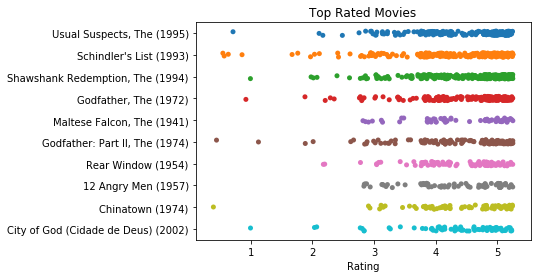

In [48]:
average_rating = ratings_sf.groupby(key_columns='movieId', operations={'avg_rating': gl.aggregate.MEAN('rating'),
                                                                       'count': gl.aggregate.COUNT()})

top_rated = average_rating[(average_rating['count'] > 50)].join(movies_sf['movieId','title']).topk('avg_rating')

top_ratings = top_rated.join(ratings_sf['movieId','rating'])
RatingStripPlot(top_ratings, 'title', 'Top Rated Movies',)

It appears the 70' and '90s were good decades for cinema.  Both produced 3 movies in the top ten.  In addition, The Godfather series has its first 2 movies in the top 6 movies.  As interesting as this plot is, not much inference can be drawn.  All we know with the plot is that MovieLens users liked these relatively popular movies.  Lets move forward by filtering based on various attributes to gain a better understanding of the data.   

<h4> Most Rated Movies </h4>  

To begin, we look at ratings based on popularity by following a similar process listed above when we were finding the ratings for the top 10 movies with the highest average rating.  The key differences in the process are as follows:  
- **average_rating** is not created and we use **count** to find the top 10 movies with the most ratings.
- **top_rated** is sorted to order movies when the **HorzBarChart()** function is used to plot the top 10 most rated movies.
- The **order** option is used in **RatingStripPlot()** to view movie ratings in the same order as the horizontal bar plot.

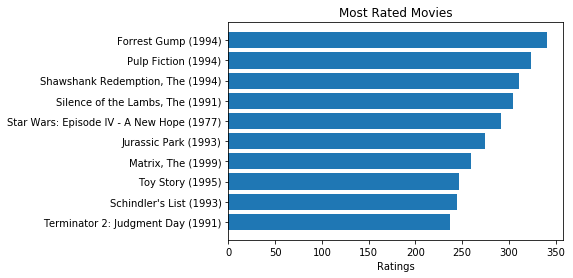

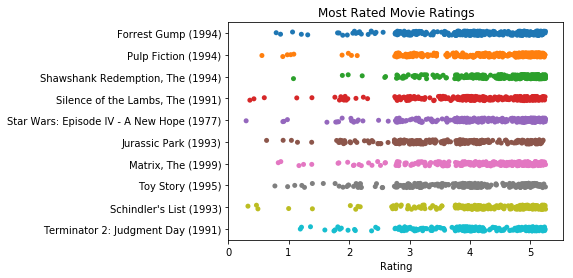

In [49]:
movie_rating_count = ratings_sf.groupby(key_columns='movieId', operations={'count': gl.aggregate.COUNT()})

most_rated = movie_rating_count.join(movies_sf['movieId','title']).topk('count').sort('count')

HorzBarChart(most_rated['count'], utf8encoding(most_rated['title']), 'Ratings', 'Most Rated Movies')

most_rated_ratings = most_rated.join(ratings_sf['movieId','rating'])
RatingStripPlot(most_rated_ratings, 'title', 'Most Rated Movie Ratings', 
                utf8encoding(list(most_rated.sort('count',ascending=False)['title'])))

Based on popularity, it can be surmised that during the entire implementation of MovieLens, its hayday with the most number of active users rating movies was a period during or shortly after the early 90s.  9 out of 10 of the top rated movies were released in the 90s.  More specificially, 8 of the 9 released in a period from 1991-1995.  The validity of this hypothesis will be further investigated during the use of the **timestamp** attribute within <u><i>ratings.csv</i></u>.

<h4> Most Tagged Movies </h4>  

Similar to ratings, tags can also be a viable measure of movie popularity.  To view plots and how they differ from ratings, the same procedure is followed but instead of the <u><i>ratings.csv</i></u> to get the top 10 movies, <u><i>tags.csv</i></u> is used. 

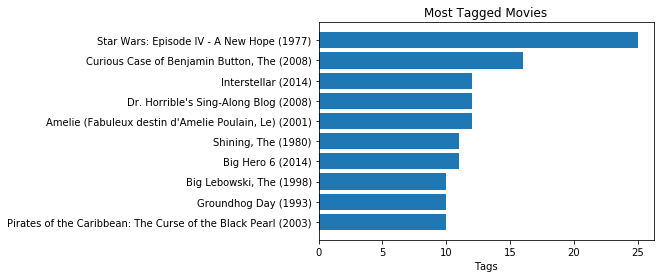

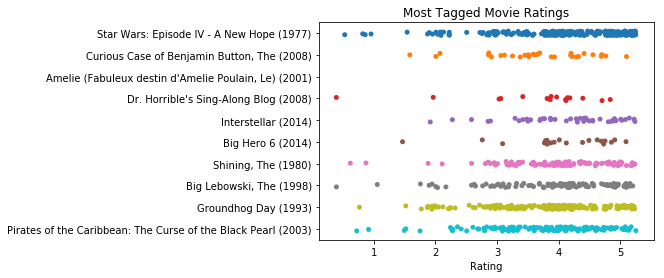

In [92]:
movie_tag_count = tags_sf.groupby(key_columns='movieId', operations={'count': gl.aggregate.COUNT()})

most_tagged = movie_tag_count.join(movies_sf['movieId','title']).topk('count').sort('count')

HorzBarChart(most_tagged['count'], frenchepatch((most_tagged['title'])), 'Tags', 'Most Tagged Movies')

most_tagged_ratings = most_tagged.join(ratings_sf['movieId','rating'])
RatingStripPlot(most_tagged_ratings, 'title', 'Most Tagged Movie Ratings', 
               utf8encoding(frenchepatch(list(most_tagged.sort('count',ascending=False)['title']))))

Quite a different story can be pieced together from tag popularity.  7 out of the 10 movies were released from 1998-2008.  A plethora of reason come to mind as to this deviation.  The tags feature could have not been implemented until the late 90s, hence why we do not see the same movies in rating popularity.  Pending a MovieLens user can add multiple tags to a movie, it is possible the identified power user, userId *547*, was primarily active during a period when these top 10 tagged movies were released or the user preferred to tag movies from the time period.  Domain knowledge of the MovieLens database would be requied to confirm any of these assumptions.  However, the assumptions will be further investigated using the **timestamp** attribute within <u><i>tags.csv</i></u>.

<h3>Time Related Attributes</h3>  

As done for previous sections, the plotting function **TagsRatingsTimeSeries()** is generated to plot both tag frequency and rating frequency for a given time horizon.  There are two separate scales on the y axis for each attribute since they reside on different scales.  The plot will allow us to further investigate hypotheses gathered from the *Most Rated* and *Most Tagged* sections.

In [93]:
def TagsRatingsTimeSeries(ratings_x, ratings_y, tags_x, tags_y, x_label, plot_title):
    f, ax1 = plt.subplots(figsize=(20,5))
    ax1.plot(ratings_x, ratings_y, 'b')
    ax2 = ax1.twinx()
    ax2.plot(tags_x, tags_y, 'g')
    ax1.set(xlabel = x_label, ylabel = 'Number of Ratings')
    ax2.set(ylabel = 'Number of Tags', title = plot_title)
    plt.show()

<h4>Ratings and Tags by Year</h4>  

A time horizon of year coinsides nicely with the previous visualizations made since release years were noted.  To plot rating and tag frequencies by year, the original SFrame goes through a series of steps to properly aggregate it:  
- The year is extracted from the datetime attribute, **timestamp**, by using **split_datetime()**.
- The newly created attribute **timestamp.year** is used to group ratings or tags using **groupby()**.
- The manipulated SFrame is sorted by **timestamp.year** and stored as a new SFrame for plotting with **TagsRatingsTimeSeries**.

In [94]:
tags_year = tags_sf.split_datetime('timestamp',limit=['year']
                                  ).groupby(key_columns='timestamp.year', operations={'count': gl.aggregate.COUNT()}
                                           ).sort(['timestamp.year'])

ratings_year = ratings_sf.split_datetime('timestamp',limit=['year']
                                        ).groupby(key_columns='timestamp.year', operations={'count': gl.aggregate.COUNT()}
                                              ).sort(['timestamp.year'])

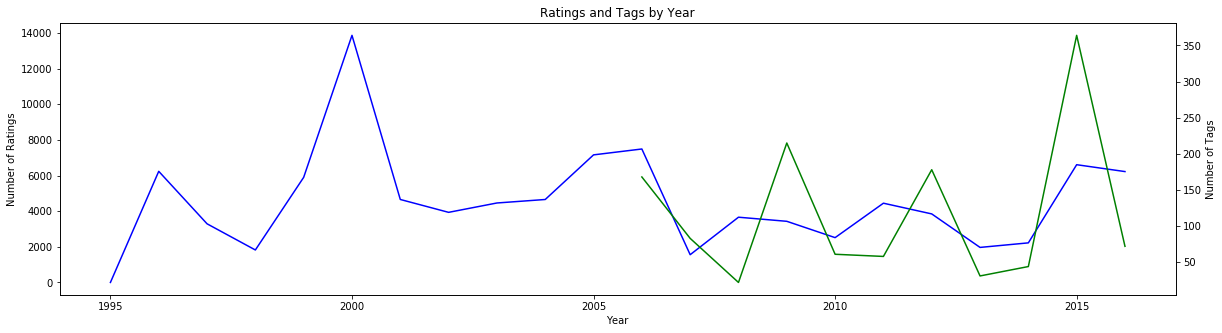

In [95]:
TagsRatingsTimeSeries(ratings_year['timestamp.year'], ratings_year['count'], 
                      tags_year['timestamp.year'], tags_year['count'], 
                      'Year', 'Ratings and Tags by Year')

We observe a spike in **ratings** during *2000* of 14,000, more than twice as many than in most other years.  This is a bit later than our predicted range of when more ratings were being made but not far off.  Practical reasoning can find justification as there may be a delay after a movie release before it can be consumed outside of theaters.  At which point, there may be an even longer delay depending on when a MovieLens user decided to watch it.  

Moreover, we see that **tags** aren't recorded in MovieLens until *2006*.  This is consistent with an option determined in *Most Tagged* where the shift in time period for movie tag popularity versus movie rating popularity could be because the tagging feature was not implemented until later on in MovieLens' existence.  Lastly, there is a spike in 2015 of roughly 375 tags recorded in *2015*.  Power user userId *547* recorded about 400 tags over the course of the dataset.  It would be interesting to see if this power user is the reasoning behind the spike.

<h4> Genres </h4>  

During simple statistics, we uncovered that *Drama* and *Comedy* appeared to be the most popular type of movie released.  We will plot rating frequency to see if this unbalanced mix of genres carries over.  Similar steps are followed as with rating frequency and tag frequency by movie, but a couple additional steps are indicated below:
- Since multiple genres can describe a movie, each genre in **genre_list** must be converted into separate row with the **stack()** function.
- **stacked_movies** is used to obtain **ratings** for each genre on a particular movie since we all not filtering top genres and the **movieId** attribute is required to join with **ratings_sf**

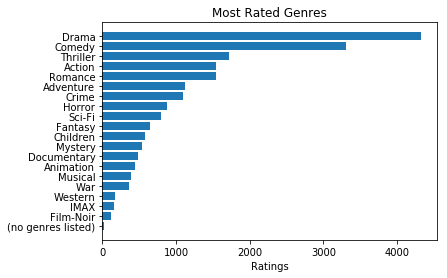

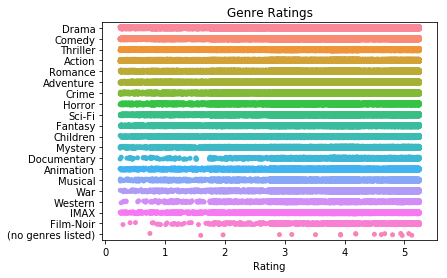

In [96]:
stacked_movies = movies_sf['movieId','title','genre_list'].stack('genre_list', new_column_name='genre')

most_rated_genre = movie_rating_count.join(stacked_movies['movieId','genre'])
most_rated_genre = most_rated_genre.groupby(key_columns='genre', operations={'count': gl.aggregate.COUNT()}).sort('count')

HorzBarChart(most_rated_genre['count'], most_rated_genre['genre'], 'Ratings', 'Most Rated Genres')

genre_ratings = stacked_movies.join(ratings_sf['movieId','rating'])
RatingStripPlot(genre_ratings, 'genre', 'Genre Ratings', 
               list(most_rated_genre.sort('count',ascending=False)['genre']))
    

It appears the unbalanced genres mix carries over in the number of ratings per movie genre.  Additionally, it appears movie genre popularity does not equate to movie quality.  The ratings by genre span across the entire range of potential ratings.  Each genre appears to produce blockbuster hits and duds with similar frequency even with an unbalanced mix of movie genres being produced.

<h2> Modeling and Evaluation 1 </h2>  
Train and adjust parameters.

In [28]:
title_ratings = ratings_sf.join(movies_sf)
train, test = gl.recommender.util.random_split_by_user(title_ratings,
                                                    user_id="userId", item_id="title",
                                                    max_num_users=100, item_test_proportion=0.2)

In [36]:
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

In [41]:
r=2
print(r)

In [ ]:
for item in params['item_id']:
    print item
    for k in params['only_top_k']:
        print '    ',k
        for sim_type in 

In [30]:
params = {'user_id': 'userId', 
          'item_id': ['title','genres','genre_list'], 
          'target': 'rating',
          'only_top_k': [5, 15, 25], 
          'similarity_type': ['cosine','pearson','jaccard']}

job = gl.model_parameter_search.create( (train,test),
        gl.recommender.item_similarity_recommender.create,
        params,
        max_models=27,
        environment=None)

ValueError: Provided model_factory <function create at 0x11337f0c8> not currently supported for automatic model parameter search. For a list of supported models  check graphlab.model_parameter_search.create documentation. You may also create custom model factories for use with graphlab.random_search or graphlab.grid_search.

<h2> Modeling and Evaluation 2 </h2>  
Evaluate and compare.

<h2> Modeling and Evaluation 3 </h2>  
Visualize results.

<h2> Modeling and Evaluation 4 </h2>  
Summarize the ramifications.

<h2> Deployment </h2>  
Be critical of your performance and tell the reader how your current model might be usable by other parties.  Did you achieve your goals?  If not, can you reign in the utility of you modeling?  How useful is your model for interested parties (i.e. the companies or organizations that might want to use it)?  How would you you deploy your model to interested parties.  What other data should be collected?  How often would the model need to be updated, etc?

<h2> Exceptional Work </h2>  
You have free reign to provide additional analyses or combine analyses

<h4> Resources </h4>  

*MovieLens Dataset*  
<sup>[1]</sup> F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages. DOI=http://dx.dio.org/10.1145/2827872  
  
*GraphLab API Documentation*  
<sup>[2]</sup> Turi. 2016. GraphLab Create API Documentation. https://turi.com/products/create/docs  
<sup>[3]</sup> Turi. 2016. Turi Machine Learning Platform User Guide. https://turi.com/learn/userguide/index.html  
  
*MSDS 7331: DataMiningNotebooks*  
<sup>[4]</sup> Eric Larson. 13. Recommendation Systems.ipynb. (2017) Southern Methodist University. https://github.com/elarson/DataMiningNotebooks/blob/master/13.%20Recommendation%20Systems.ipynb 